# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Load Dataset

In [2]:
df = pd.read_csv('data_files/concatted_data.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.rename(columns={'realSum': 'ROOM_PRICE'})

In [3]:
df.head(3)

,ROOM_PRICE,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,194.033698,Private room,False,True,2,False,1,0,10,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,344.245776,Private room,False,True,4,False,0,0,8,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,264.101422,Private room,False,True,2,False,0,1,9,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ROOM_PRICE                  51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  int64  
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  int64  
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

In [5]:
# convert data type to int

df['person_capacity'] = df['person_capacity'].astype(int)

Group features

In [6]:
categorical_features = ['room_type', 'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz', 'city', 'is_weekend']
continuous_num_features = ['guest_satisfaction_overall', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']
ordinal_num_features = ['person_capacity', 'cleanliness_rating', 'bedrooms'] 

num_features = continuous_num_features + ordinal_num_features

## Handle Missing Values

In [7]:
missing_summary = pd.DataFrame({
    'Feature': df.columns,
    'Missing Count': df.isna().sum(),
    'Missing Percentage (%)': (df.isna().sum() / len(df)) * 100
})

# Filter only features with missing values
#missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

missing_summary = missing_summary.sort_values(by='Missing Count', ascending=False).reset_index(drop=True)

# Display the summary table
missing_summary

,Feature,Missing Count,Missing Percentage (%)
0,ROOM_PRICE,0,0.0
1,dist,0,0.0
2,city,0,0.0
3,lat,0,0.0
4,lng,0,0.0
5,rest_index_norm,0,0.0
6,rest_index,0,0.0
7,attr_index_norm,0,0.0
8,attr_index,0,0.0
9,metro_dist,0,0.0


## Detect Duplicates

In [8]:
# Detect duplicate rows based on the 'features' list
duplicate_rows = df.duplicated(keep='first')

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Handle Outliers (numerical features)

Utility functions

In [9]:
from scipy.stats import skew

def skew_category(value):
    if value > 0.5:
        return "Right Skewed"
    elif value < -0.5:
        return "Left Skewed"
    else:
        return "Symmetric"


def detect_outliers(dataframe):
    num_features = continuous_num_features + ordinal_num_features

    Q1 = dataframe[num_features].quantile(0.25)
    Q3 = dataframe[num_features].quantile(0.75)
    IQR = Q3 - Q1

    outliers_IQR = ((dataframe[num_features] < (Q1 - 1.5 * IQR)) | (dataframe[num_features] > (Q3 + 1.5 * IQR)))

    outliers_count_IQR = outliers_IQR.sum()

    outliers_percentage = (outliers_count_IQR / df.shape[0]) * 100

    skewness = dataframe[num_features].apply(lambda x: skew(x.dropna()))

    # Prepare summary statistics DataFrame
    num_desc_stats = pd.DataFrame({
        # 'min': df[num_features].min(),
        # 'max': df[num_features].max(),
        # 'mean': df[num_features].mean(),
        # 'median': df[num_features].median(),
        # 'std': df[num_features].std(),
        'skewness': skewness,
        'outlier_count': outliers_count_IQR,
        'outliers (%)': outliers_percentage,
        'skew': skewness.apply(skew_category)
    })

    num_desc_stats = num_desc_stats.sort_values(by='outlier_count', ascending=False).reset_index()
    return num_desc_stats

def visualize_num_features_dist(dataframe, features_cols, plot_title="Feature Distributions"):
    num_plots = min(len(features_cols), 12)  
    rows, cols = 4, 3

    fig, axes = plt.subplots(rows, cols, figsize=(18, 16))

    axes = axes.flatten()

    for i, col in enumerate(features_cols[:num_plots]):
        sns.kdeplot(dataframe[col], ax=axes[i], fill=True, color='skyblue')
        axes[i].set_title(col, fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    # Set the title for the whole figure
    fig.suptitle(plot_title, fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()

### Detect Outliers using IQR

In [10]:
outliers_data = detect_outliers(df)

outliers_data

,index,skewness,outlier_count,outliers (%),skew
0,bedrooms,1.367736,15374,29.732918,Right Skewed
1,metro_dist,4.060327,5051,9.768503,Right Skewed
2,attr_index,2.759900,2237,4.326300,Right Skewed
3,rest_index,1.694307,2166,4.188988,Right Skewed
4,guest_satisfaction_overall,-3.174816,2102,4.065214,Left Skewed
5,attr_index_norm,2.193103,1852,3.581720,Right Skewed
6,cleanliness_rating,-2.850204,1830,3.539173,Left Skewed
7,dist,1.731144,1746,3.376719,Right Skewed
8,rest_index_norm,1.097423,998,1.930106,Right Skewed
9,lng,0.033300,0,0.000000,Symmetric


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

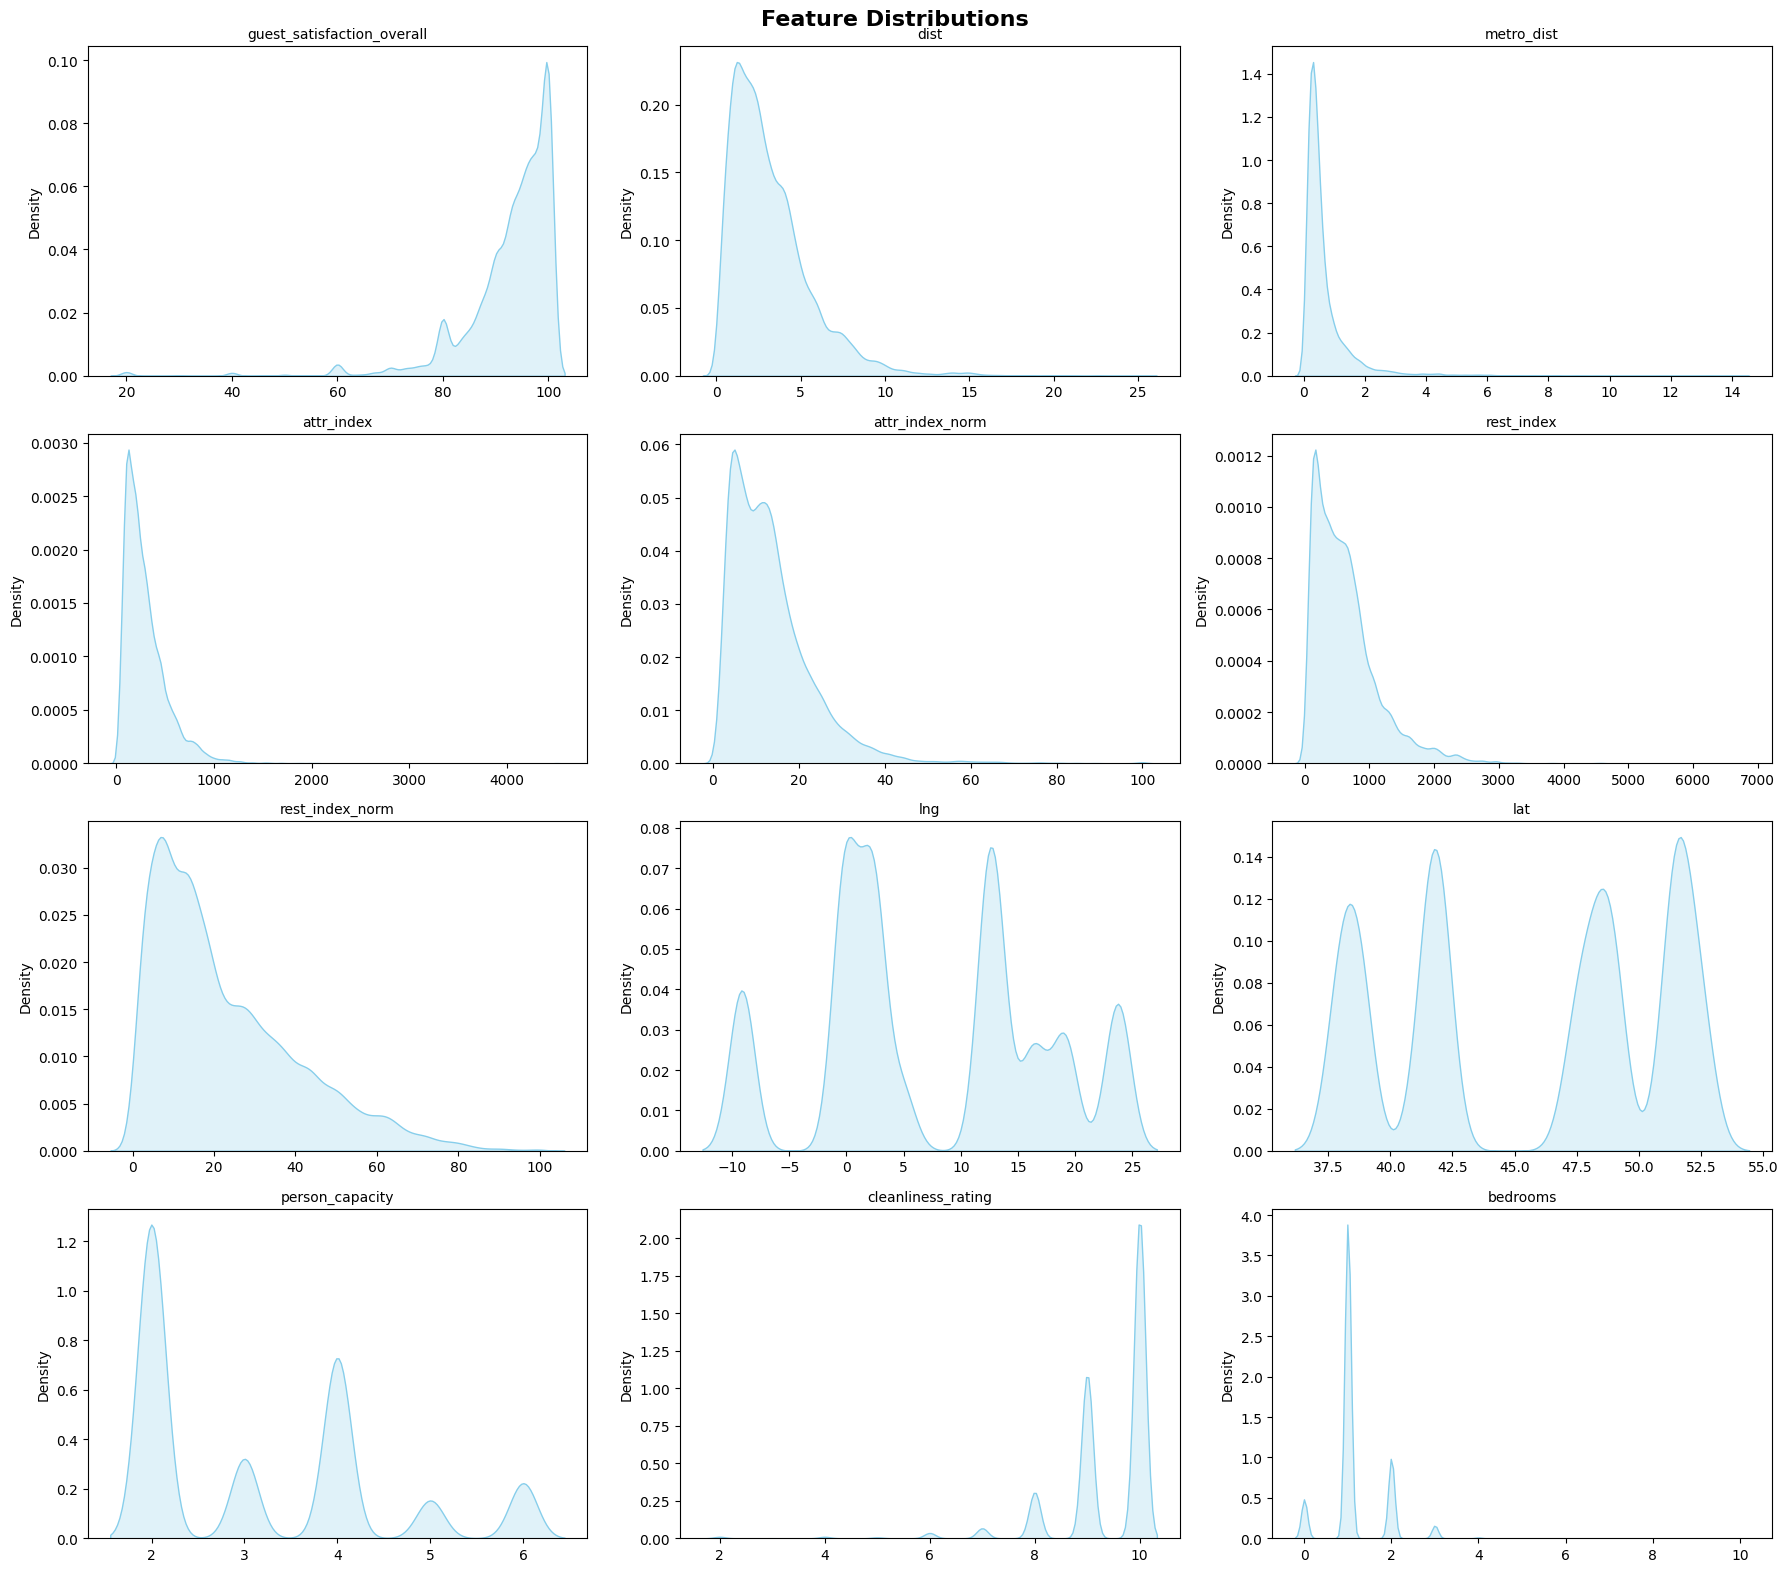

In [11]:
visualize_num_features_dist(df, num_features)

## Feature Transformation

### Standardization (Numerical Features)

In [11]:
def transform_skewed_features(df, skewness, skew_threshold=0.5):
    transformed_df = df.copy()
    
    for feature in skewness.index:
        if skewness[feature] > skew_threshold:
            # Log transformation for right-skewed features
            transformed_df[feature] = np.log1p(transformed_df[feature])  
        elif skewness[feature] < -skew_threshold:
            # Square root transformation for left-skewed features
            transformed_df[feature] = np.sqrt(transformed_df[feature].max() - transformed_df[feature])
    
    return transformed_df

skewness = df[num_features].apply(lambda x: skew(x.dropna()))

df_transformed = transform_skewed_features(df, skewness)

In [12]:
df_transformed.head(5)

,ROOM_PRICE,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,194.033698,Private room,False,True,1.098612,False,1,0,0.000000,2.645751,...,1.795579,1.263952,4.378149,1.642236,4.597681,2.060064,4.90569,52.41772,Amsterdam,0
1,344.245776,Private room,False,True,1.609438,False,0,0,1.414214,3.872983,...,0.397695,0.214631,6.449168,3.538673,6.731353,4.083333,4.90005,52.37432,Amsterdam,0
2,264.101422,Private room,False,True,1.098612,False,0,1,1.000000,3.605551,...,1.909292,1.537216,4.334357,1.606615,4.568371,2.034274,4.97512,52.36103,Amsterdam,0
3,433.529398,Private room,False,True,1.609438,False,0,1,1.000000,3.162278,...,0.325601,0.364557,6.203087,3.300239,6.775404,4.126708,4.89417,52.37663,Amsterdam,0
4,485.552926,Private room,False,True,1.098612,True,0,0,0.000000,1.414214,...,0.434854,0.276641,6.316858,3.410247,6.704789,4.057191,4.90051,52.37508,Amsterdam,0


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

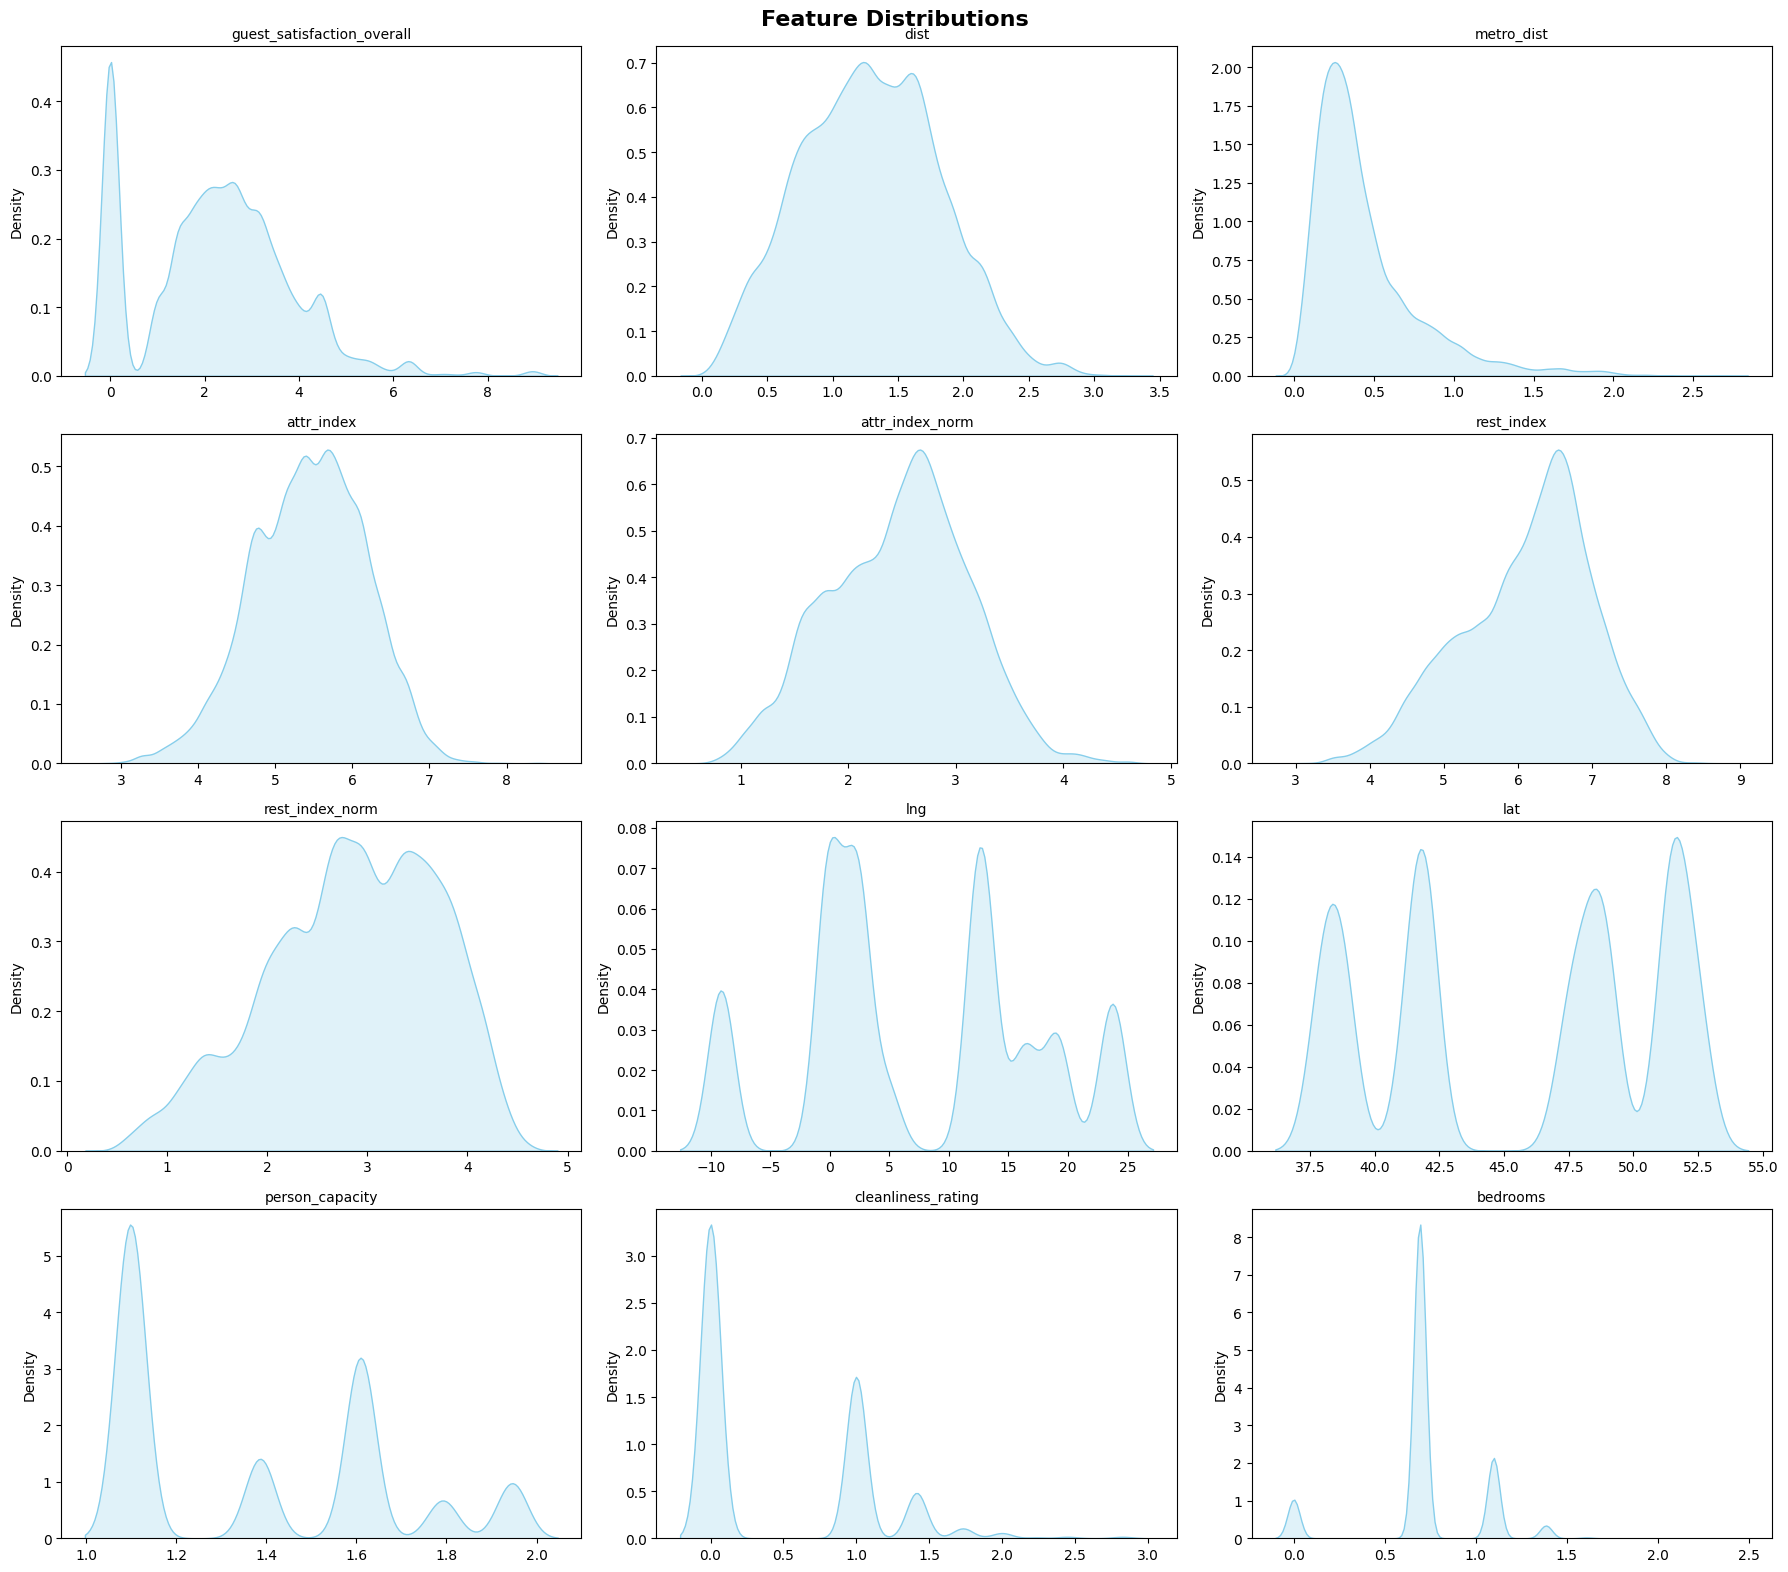

In [46]:
visualize_num_features_dist(df_transformed, num_features)

In [13]:
outliers_data = detect_outliers(df_transformed)

outliers_data

,index,skewness,outlier_count,outliers (%),skew
0,bedrooms,-0.536235,15374,29.732918,Left Skewed
1,metro_dist,1.896977,3285,6.353105,Right Skewed
2,guest_satisfaction_overall,0.454913,378,0.731042,Symmetric
3,attr_index,-0.175885,227,0.439012,Symmetric
4,rest_index,-0.446027,208,0.402267,Symmetric
5,cleanliness_rating,0.775329,153,0.295898,Right Skewed
6,attr_index_norm,-0.072576,108,0.208869,Symmetric
7,dist,0.128961,90,0.174058,Symmetric
8,rest_index_norm,-0.383192,0,0.000000,Symmetric
9,lng,0.033300,0,0.000000,Symmetric


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

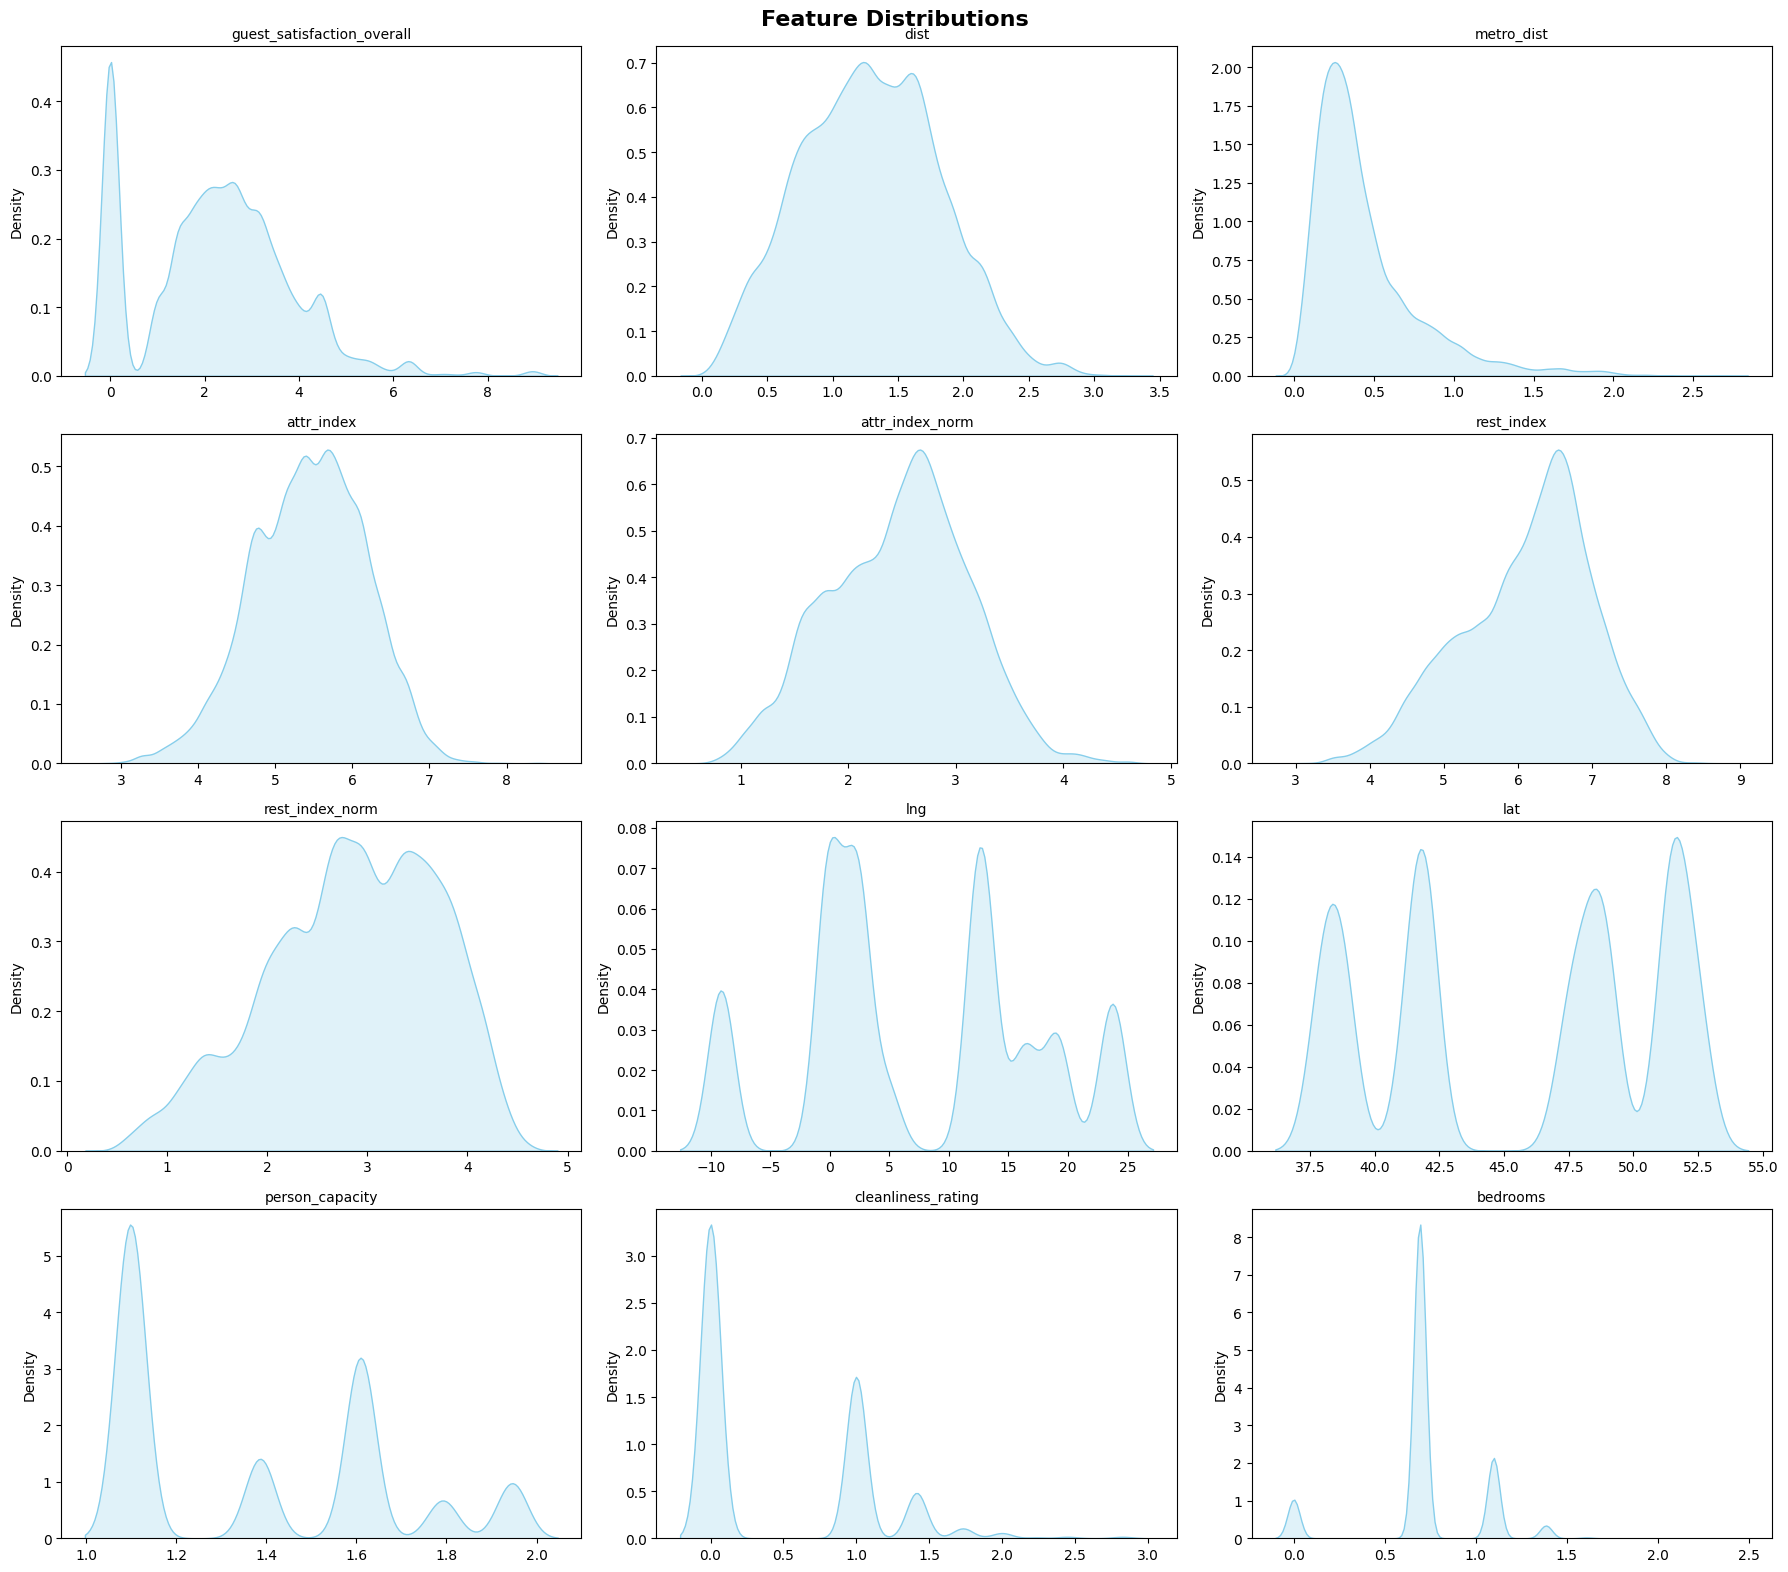

In [16]:
visualize_num_features_dist(df_transformed, num_features)

Apply cube-root transformation

In [14]:
max_value = df_transformed['bedrooms'].max()
df_transformed['bedrooms'] = np.cbrt(max_value - df_transformed['bedrooms'])

In [15]:
#df_transformed['bedrooms'] = np.cbrt(df_transformed['bedrooms'])
df_transformed['metro_dist'] = np.cbrt(df_transformed['metro_dist'])
df_transformed['cleanliness_rating'] = np.cbrt(df_transformed['cleanliness_rating'])

In [16]:
df_transformed['metro_dist'] = np.cbrt(df_transformed['metro_dist'])

In [17]:
outliers_data = detect_outliers(df_transformed)

outliers_data

,index,skewness,outlier_count,outliers (%),skew
0,bedrooms,-0.442517,15374,29.732918,Symmetric
1,metro_dist,0.015899,742,1.435009,Symmetric
2,guest_satisfaction_overall,0.454913,378,0.731042,Symmetric
3,attr_index,-0.175885,227,0.439012,Symmetric
4,rest_index,-0.446027,208,0.402267,Symmetric
5,attr_index_norm,-0.072576,108,0.208869,Symmetric
6,dist,0.128961,90,0.174058,Symmetric
7,rest_index_norm,-0.383192,0,0.000000,Symmetric
8,lng,0.033300,0,0.000000,Symmetric
9,lat,-0.179578,0,0.000000,Symmetric


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

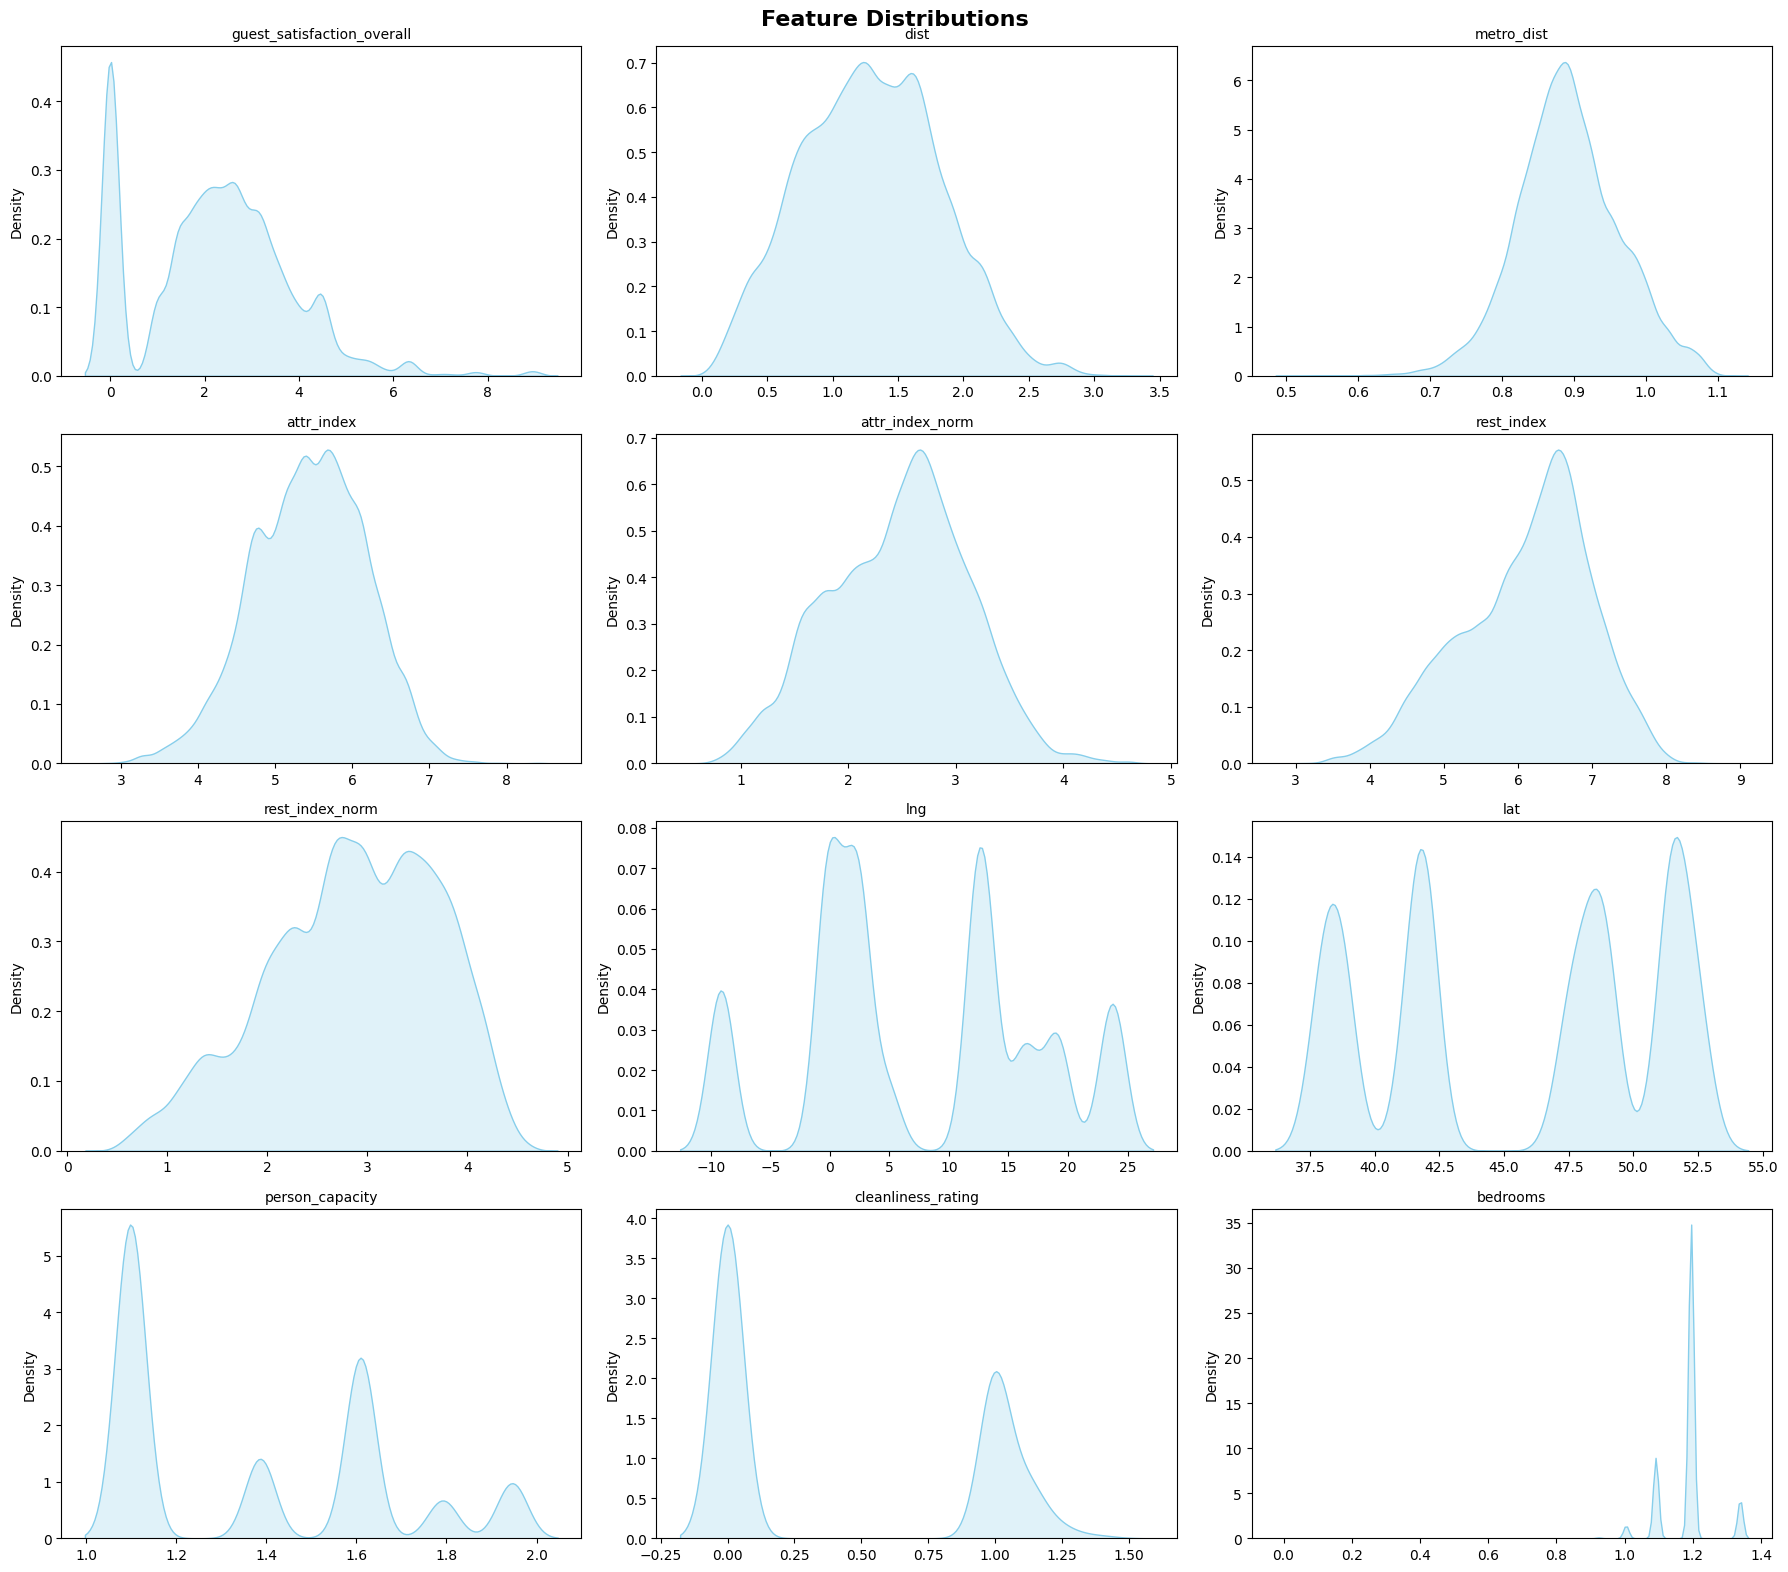

In [62]:
visualize_num_features_dist(df_transformed, num_features)

### Winsorizing (use IQR)

In [18]:
clipped_count = {}

for feature in ['metro_dist', 'guest_satisfaction_overall', 'attr_index', 'rest_index', 'attr_index_norm', 'dist']:
    lower_quantile = df_transformed[feature].quantile(0.05)
    upper_quantile = df_transformed[feature].quantile(0.95)
    
    before_clipping = df_transformed[(df_transformed[feature] < lower_quantile) | 
                                     (df_transformed[feature] > upper_quantile)].shape[0]
    
    df_transformed[feature] = df_transformed[feature].clip(lower=lower_quantile, upper=upper_quantile)
    
    clipped_count[feature] = before_clipping

print("Number of clipped data points for each feature:")
for feature, count in clipped_count.items():
    print(f"{feature}: {count}")


Number of clipped data points for each feature:
metro_dist: 5172
guest_satisfaction_overall: 2445
attr_index: 5172
rest_index: 5172
attr_index_norm: 5172
dist: 5172


In [19]:
df_transformed2 = df_transformed.copy()

In [59]:
k = 1.5 

for feature in ['metro_dist', 'guest_satisfaction_overall', 'attr_index', 'rest_index', 'attr_index_norm', 'dist']:
    Q1 = df_transformed2[feature].quantile(0.25)
    Q3 = df_transformed2[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    # Option 1: Clip outliers to the bounds
    df_transformed2[feature] = df_transformed2[feature].clip(lower=lower_bound, upper=upper_bound)

    # Option 2: Remove outliers completely
    # df_transformed = df_transformed[(df_transformed[feature] >= lower_bound) & (df_transformed[feature] <= upper_bound)]

    # Print the number of clipped or removed data points
    clipped_count = ((df_transformed2[feature] < lower_bound) | (df_transformed2[feature] > upper_bound)).sum()
    #print(f"{feature}: {clipped_count} data points adjusted.")


In [20]:
for feature in ['metro_dist', 'guest_satisfaction_overall', 'attr_index', 'rest_index', 'attr_index_norm', 'dist']:
    lower_quantile = df_transformed2[feature].quantile(0.05)  
    upper_quantile = df_transformed2[feature].quantile(0.95)  
    
    # Clip values outside the quantiles
    df_transformed2[feature] = df_transformed[feature].clip(lower=lower_quantile, upper=upper_quantile)

In [21]:
outliers_data = detect_outliers(df_transformed2)

outliers_data

,index,skewness,outlier_count,outliers (%),skew
0,bedrooms,-0.442517,15374,29.732918,Symmetric
1,guest_satisfaction_overall,-0.090595,0,0.000000,Symmetric
2,dist,0.018454,0,0.000000,Symmetric
3,metro_dist,0.144535,0,0.000000,Symmetric
4,attr_index,-0.092533,0,0.000000,Symmetric
5,attr_index_norm,-0.139008,0,0.000000,Symmetric
6,rest_index,-0.377355,0,0.000000,Symmetric
7,rest_index_norm,-0.383192,0,0.000000,Symmetric
8,lng,0.033300,0,0.000000,Symmetric
9,lat,-0.179578,0,0.000000,Symmetric


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

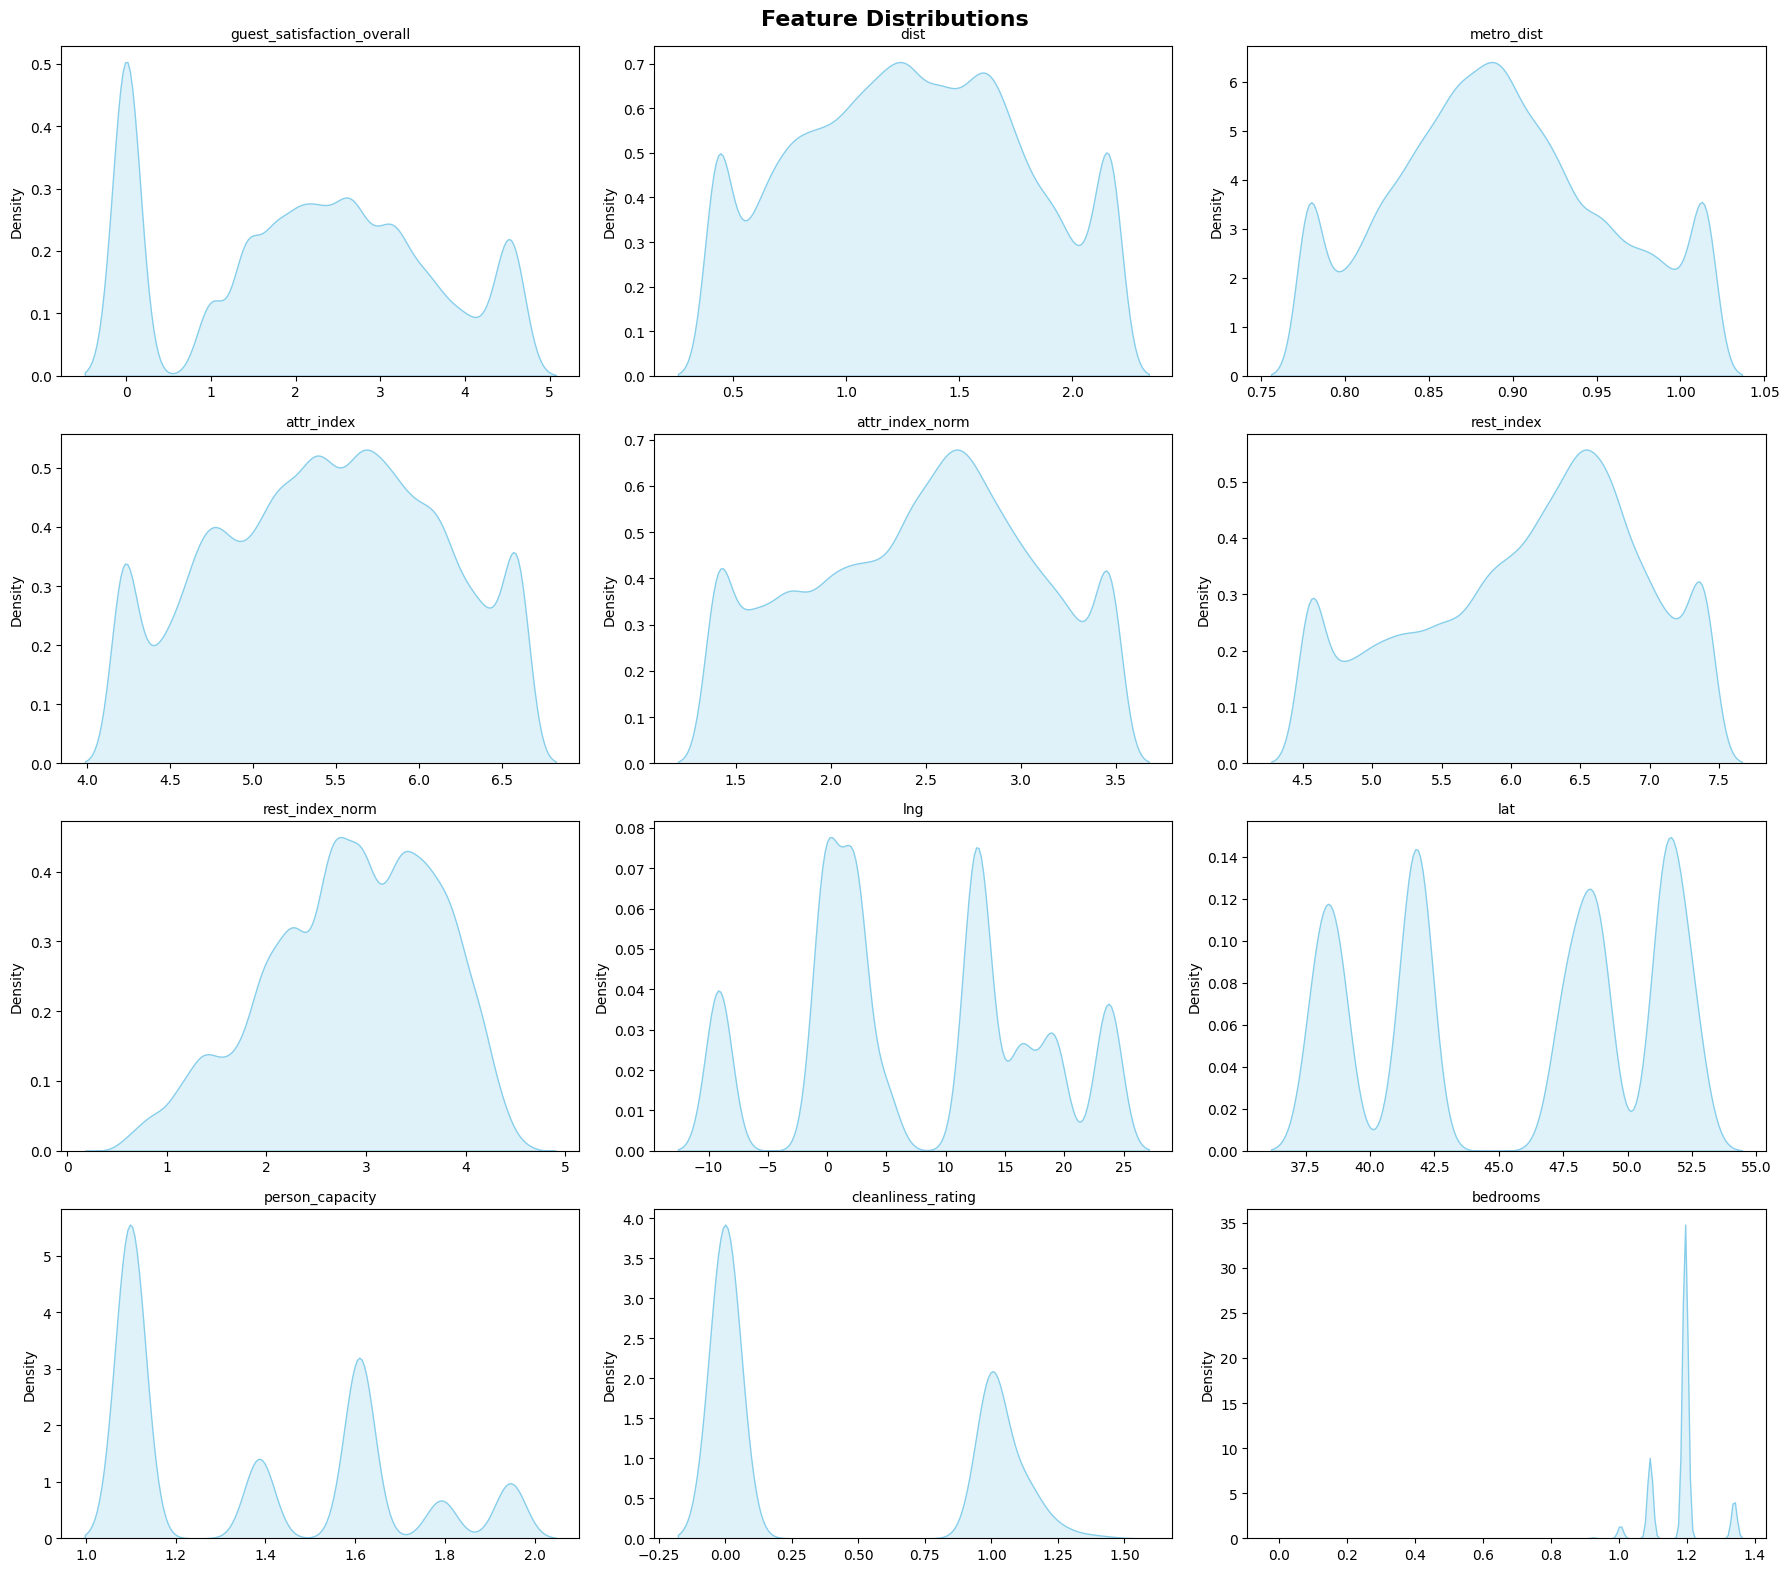

In [23]:
visualize_num_features_dist(df_transformed2, num_features)

### Feature Encoding (categorical features)

Binary Label Encoding

`room_shared`, `room_private`, `host_is_superhost`

In [35]:
df_encoded = df_transformed2.copy()

In [36]:
df_encoded['room_shared'] = df_transformed['room_shared'].map({False:0, True:1})
df_encoded['room_private'] = df_transformed['room_private'].map({False:0, True:1})
df_encoded['host_is_superhost'] = df_transformed['host_is_superhost'].map({False:0, True:1})

One Hot Encoding

`room_type` and `city`

In [37]:
one_hot_features = ['room_type', 'city']

one_hot_df = pd.get_dummies(
    df_encoded[one_hot_features], 
    prefix=one_hot_features,
    drop_first=True
).astype(int)

df_encoded = pd.concat(
    [df_encoded.drop(columns=one_hot_features), one_hot_df],
    axis=1
)

In [38]:
df_encoded.head(5)

,ROOM_PRICE,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,room_type_Shared room,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
0,194.033698,0,1,1.098612,0,1,0,0.000000,2.645751,1.194593,...,0,0,0,0,0,0,0,0,0,0
1,344.245776,0,1,1.609438,0,0,0,1.122462,3.872983,1.194593,...,0,0,0,0,0,0,0,0,0,0
2,264.101422,0,1,1.098612,0,0,1,1.000000,3.605551,1.194593,...,0,0,0,0,0,0,0,0,0,0
3,433.529398,0,1,1.609438,0,0,1,1.000000,3.162278,1.091192,...,0,0,0,0,0,0,0,0,0,0
4,485.552926,0,1,1.098612,1,0,0,0.000000,1.414214,1.194593,...,0,0,0,0,0,0,0,0,0,0


### Feature Scaling (numerical features)

Train/Test split (avoiding data leakage)

In [39]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['ROOM_PRICE'], axis=1)
y = df_encoded['ROOM_PRICE']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [40]:
X.head(5)

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,...,room_type_Shared room,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
0,0,1,1.098612,0,1,0,0.000000,2.645751,1.194593,1.795579,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1.609438,0,0,0,1.122462,3.872983,1.194593,0.425869,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1.098612,0,0,1,1.000000,3.605551,1.194593,1.909292,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1.609438,0,0,1,1.000000,3.162278,1.091192,0.425869,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1.098612,1,0,0,0.000000,1.414214,1.194593,0.434854,...,0,0,0,0,0,0,0,0,0,0


In [42]:
num_features

['guest_satisfaction_overall',
 'dist',
 'metro_dist',
 'attr_index',
 'attr_index_norm',
 'rest_index',
 'rest_index_norm',
 'lng',
 'lat',
 'person_capacity',
 'cleanliness_rating',
 'bedrooms']

Using Min-Max scaling

In [43]:
if X_train[num_features].isnull().sum().sum() > 0:
    X_train[num_features] = X_train[num_features].fillna(X_train[num_features].mean())  # Or any other imputation strategy

if X_test[num_features].isnull().sum().sum() > 0:
    X_test[num_features] = X_test[num_features].fillna(X_test[num_features].mean())  # Or any other imputation strategy

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train[num_features])
# X_test = scaler.transform(X_test[num_features])

X_train[num_features] = pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
X_test[num_features] = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)


In [46]:
X_train.head(5)

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,...,room_type_Shared room,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
10447,0,1,0.000000,1,0,0,0.000000,0.000000,0.707664,0.368529,...,0,0,0,1,0,0,0,0,0,0
12561,0,1,0.000000,0,0,0,0.707107,0.690066,0.707664,0.574710,...,0,0,0,1,0,0,0,0,0,0
15863,0,0,0.339529,1,0,0,0.000000,0.487950,0.707664,0.536395,...,0,0,0,0,1,0,0,0,0,0
13936,0,1,0.000000,1,1,0,0.707107,0.436436,0.707664,0.766174,...,0,0,0,0,1,0,0,0,0,0
7939,0,1,0.000000,0,0,1,0.000000,0.617213,0.707664,0.258111,...,0,0,1,0,0,0,0,0,0,0


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

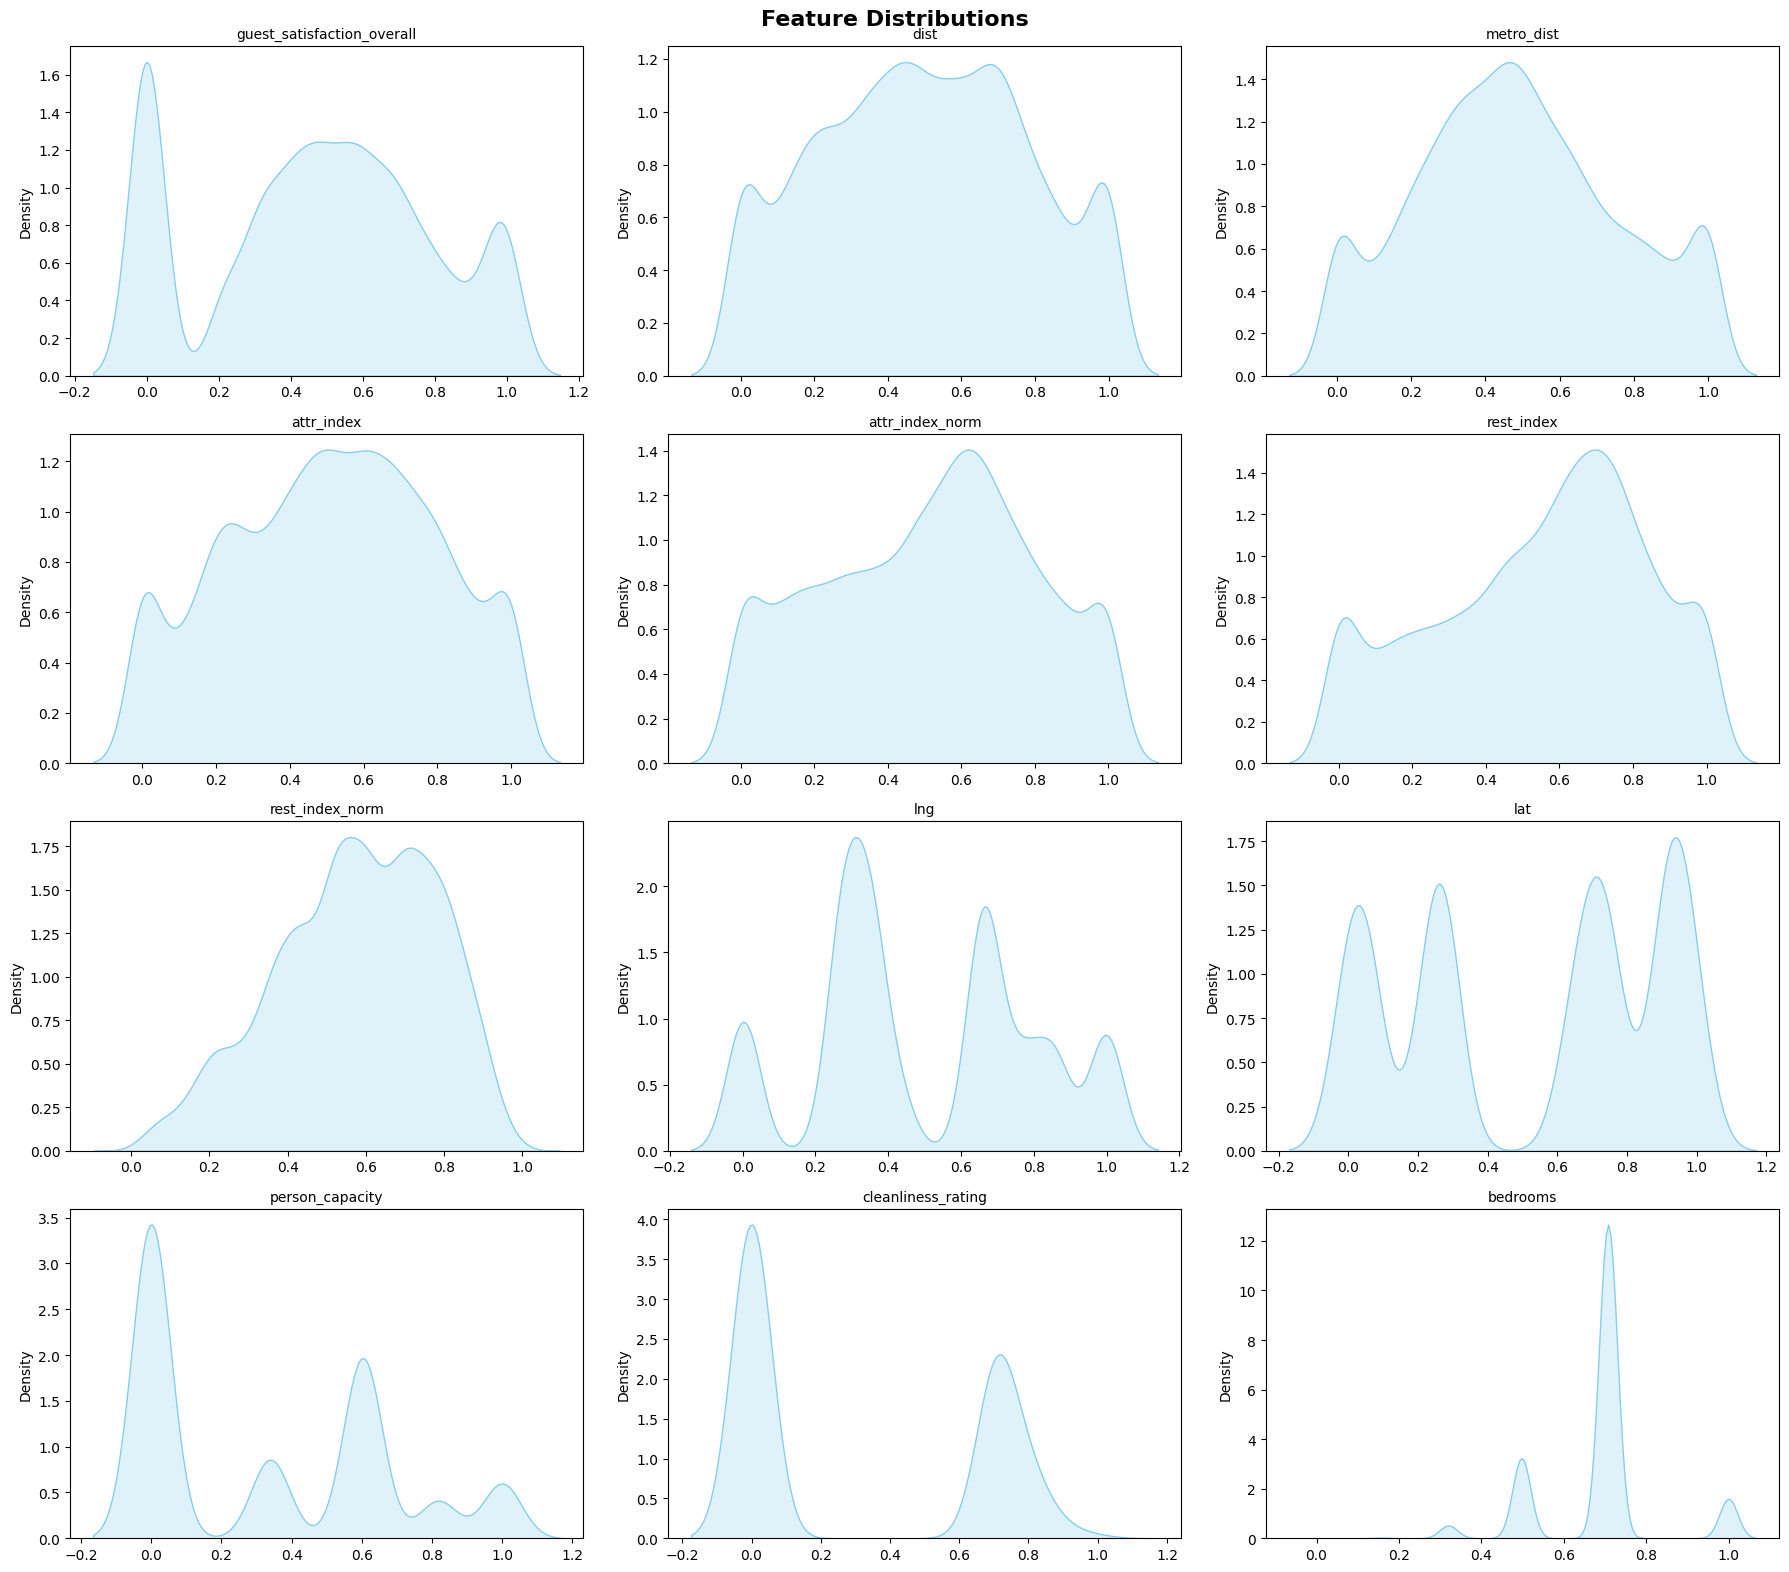

In [47]:
visualize_num_features_dist(X_train, num_features)

## Feature Selection


- `attr_index_norm` and `rest_index_norm` are the transformed features of `attr_index` and `rest_index` accordingly.
- Discard `attr_index` and `rest_index` as they have more outliers than `attr_index_norm` and `rest_index_norm`.

## Feature Extraction

In [48]:
X_train['attraction_accessibility'] = X_train['attr_index_norm'] / X_train['dist']
X_test['attraction_accessibility'] = X_test['attr_index_norm'] / X_test['dist']

X_train['rest_prox_score'] = X_train['rest_index_norm'] / X_train['metro_dist']
X_test['rest_prox_score'] = X_test['rest_index_norm'] / X_test['metro_dist']

In [49]:
X_train.head(5)

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,...,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna,attraction_accessibility,rest_prox_score
10447,0,1,0.000000,1,0,0,0.000000,0.000000,0.707664,0.368529,...,0,1,0,0,0,0,0,0,2.713494,3.185286
12561,0,1,0.000000,0,0,0,0.707107,0.690066,0.707664,0.574710,...,0,1,0,0,0,0,0,0,1.036665,1.127822
15863,0,0,0.339529,1,0,0,0.000000,0.487950,0.707664,0.536395,...,0,0,1,0,0,0,0,0,0.465751,13.357558
13936,0,1,0.000000,1,1,0,0.707107,0.436436,0.707664,0.766174,...,0,0,1,0,0,0,0,0,0.164672,0.408114
7939,0,1,0.000000,0,0,1,0.000000,0.617213,0.707664,0.258111,...,1,0,0,0,0,0,0,0,2.260696,1.608659


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

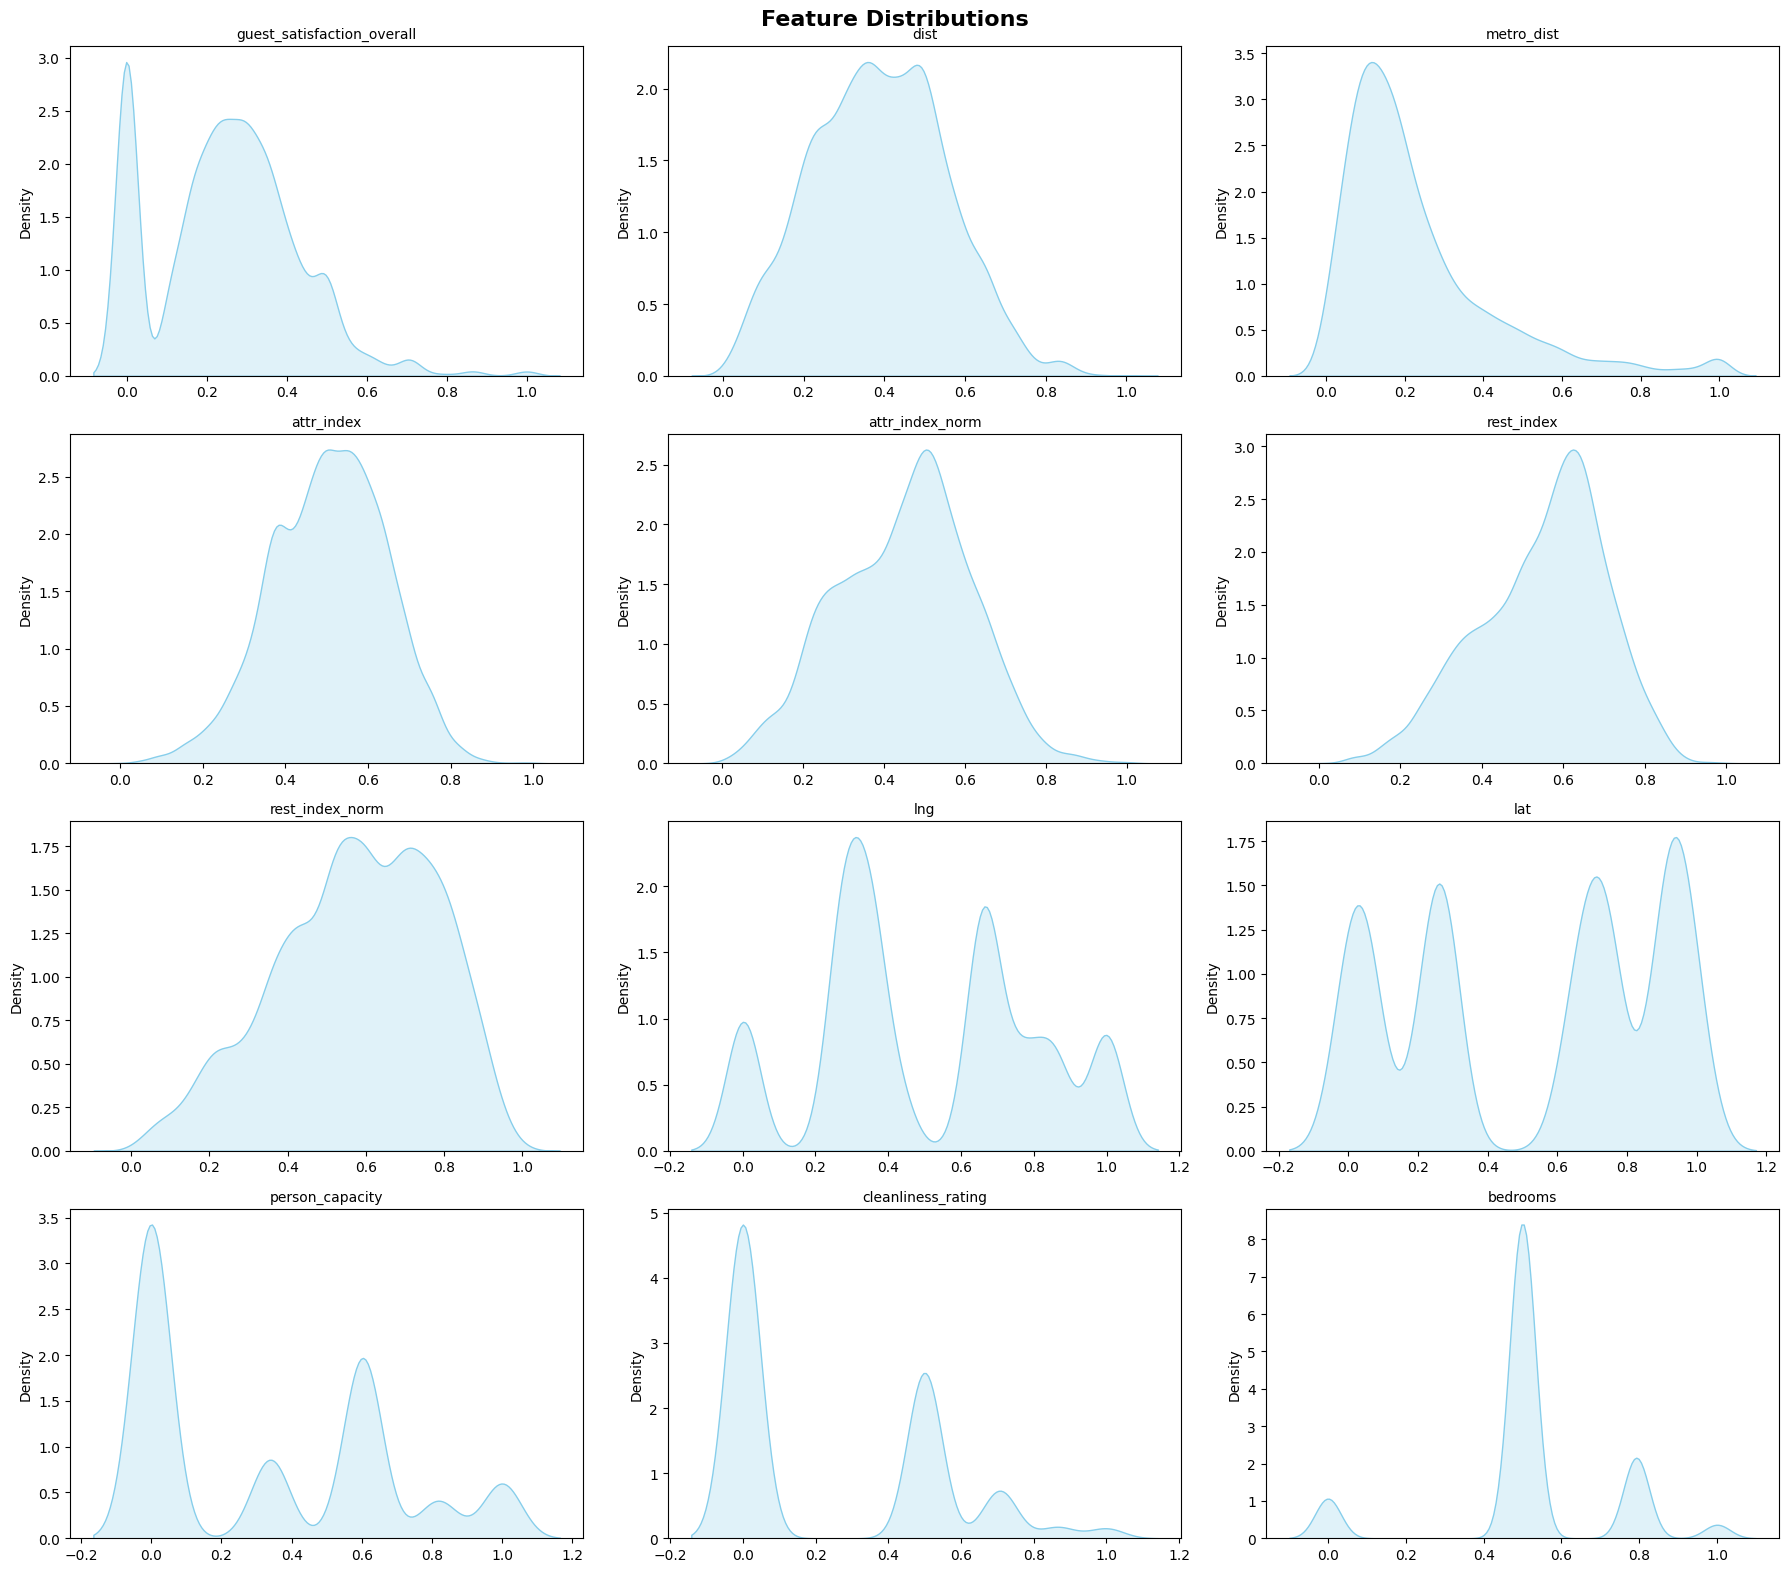

In [88]:
visualize_num_features_dist(X_train, features_cols= num_features + ['attraction_accessibility', 'rest_prox_score'])

## Save Datasets

In [23]:
# X_train_df = pd.DataFrame(X_train)
# y_train_df = pd.DataFrame(y_train)

# X_test_df = pd.DataFrame(X_test)
# y_test_df = pd.DataFrame(y_test)

X_train.to_csv('data_files/preprocessed_X_train.csv', index=False)
y_train.to_csv('data_files/y_train.csv', index=False)

X_test.to_csv('data_files/preprocessed_X_test.csv', index=False)
y_test.to_csv('data_files/y_test.csv', index=False)

In [50]:
X_train.to_csv('data_files/preprocessed_X_train3.csv', index=False)
y_train.to_csv('data_files/y_train3.csv', index=False)

X_test.to_csv('data_files/preprocessed_X_test3.csv', index=False)
y_test.to_csv('data_files/y_test3.csv', index=False)